In [1]:
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
import collections
import itertools
import json
import folium
import folium.plugins as plugins
import numpy as np
import csv
import operator
from operator import itemgetter

In [3]:
import folium
import geopandas as gpd
from shapely.geometry import Point, Polygon
import json

In [4]:
from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness

### Selecting data for only January and then calculating duration and speed (in meters per minute)

In [5]:
taxi_data = pd.read_csv('taxi_flow_2016-01_2016-02_2016-03.csv')
taxi_data = taxi_data[taxi_data['stime']<'2016-02-01']
taxi_data['ttime'], taxi_data['stime'] = pd.to_datetime(taxi_data['ttime']), pd.to_datetime(taxi_data['stime'])
taxi_data['duration'] = (taxi_data['ttime']-taxi_data['stime']).dt.components['minutes']
taxi_data = taxi_data[taxi_data['duration']!=0]
taxi_data['speed'] = round(taxi_data['d']/taxi_data['duration'],2)*1000


In [6]:
taxi_data.head()

stime               ttime       sx       sy       tx       ty  \
0 2016-01-01 00:31:23 2016-01-01 00:39:36 -73.9534  40.8036 -73.9492  40.7941   
1 2016-01-01 00:26:08 2016-01-01 00:39:46 -73.9434  40.8243 -73.9320  40.8502   
2 2016-01-01 00:25:05 2016-01-01 00:38:43 -73.9378  40.8144 -73.9516  40.8119   
3 2016-01-01 00:18:54 2016-01-01 00:39:30 -73.9411  40.7883 -73.9362  40.8207   
4 2016-01-01 00:30:03 2016-01-01 00:39:51 -73.9463  40.8211 -73.9680  40.8031   

      d  sregion  tregion  duration  speed  
0  1.01       84       38         8  130.0  
1  2.28       30       80        13  180.0  
2  1.36       53      137        13  100.0  
3  3.97       32      119        20  200.0  
4  2.21       50        6         9  250.0

In [7]:
taxi_data_abstract = taxi_data[['sregion', 'tregion', 'speed']]

In [8]:
def average_speed(abstract_data):
    uni_sregions = abstract_data['sregion'].unique()
    regions_distance = []
    for sregion in uni_sregions:
        specific_sregion = abstract_data[abstract_data['sregion']==sregion]
        uni_tregions = specific_sregion['tregion'].unique()
        for tregion in uni_tregions:
            distance = round(specific_sregion[specific_sregion['tregion']==tregion]['speed'].mean(),2)
            regions_distance.append([sregion, tregion, distance])
    average_speed_df = pd.DataFrame(regions_distance, columns=['sregion', 'tregion', 'speed'])
    return average_speed_df
                                    

In [9]:
regions_distance_df = average_speed(taxi_data_abstract)

In [10]:
regions_distance_df = regions_distance_df.drop_duplicates()

### Extracted only the columns needed for building a graph 

In [11]:
regions_distance_df.head()

sregion  tregion   speed
0       84       38  200.54
1       84       41  162.35
2       84      126  188.76
3       84      114  186.16
4       84      164  178.74

In [12]:
# Building a directed graph with start nodes and end nodes along weights
def add_graph(df):
    G = nx.DiGraph()
    for i in range(len(df)):
        start_node = int(df.loc[i]['sregion'])
        end_node = int(df.loc[i]['tregion'])
        speed = df.loc[i]['speed']
        G.add_edge(start_node, end_node, weight=speed)
    return G
    

In [13]:
G =add_graph(regions_distance_df)

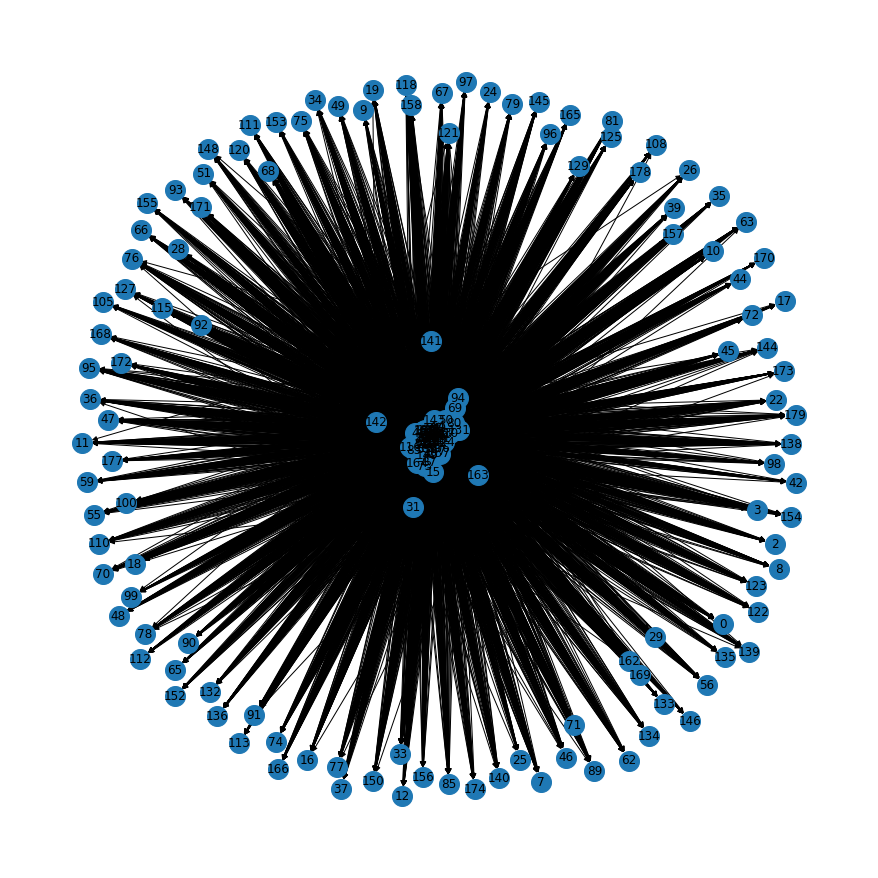

In [14]:
plt.figure(figsize=(12,12))
pos_spring = nx.spring_layout(G)
nx.draw(G, pos = pos_spring, with_labels=True, node_size=400)

In [15]:
# Checking which edges are have speed values lower than mean and calling them slow. 
# Similarly edges with speed higher than average are called as fast.

slow = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < 200]
fast = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 200]

### Plotting the edges with low values in green and with high values in pink

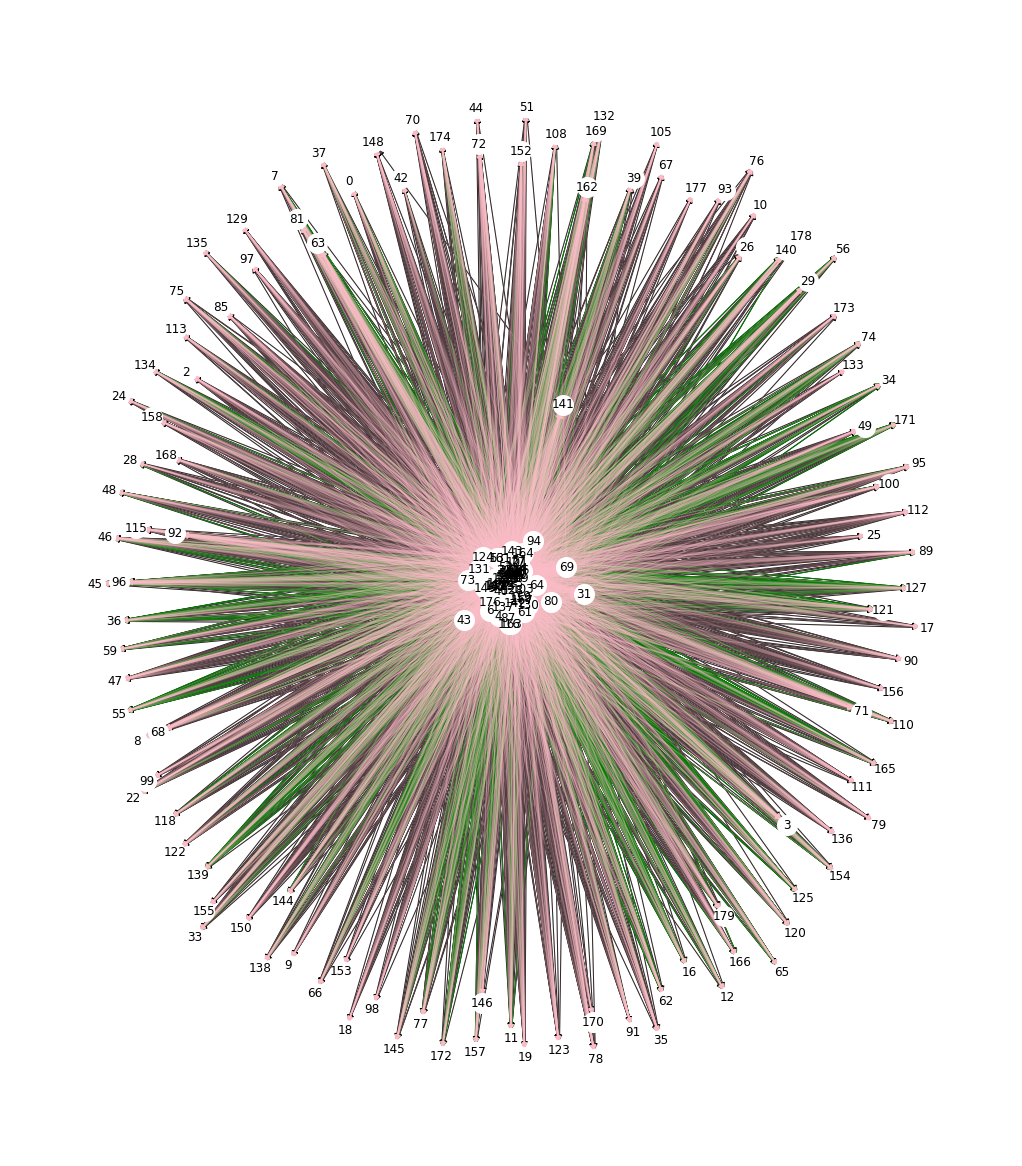

In [16]:
plt.figure(figsize=(14,16))
pos_spring = nx.spring_layout(G)
nx.draw(G, pos = pos_spring, with_labels=True, node_size=400, node_color='white')
nx.draw_networkx_edges(G, pos=pos_spring, edgelist=slow,edge_color='green', width=1)
nx.draw_networkx_edges(G, pos=pos_spring, edgelist=fast, width=1, alpha=0.2, edge_color='pink', style='solid')
plt.show()

### Calculating the degree centrality of the graph. Selecting 10 nodes with high centrality and 10 nodes with low centrality.

In [17]:
def cen_measure(cen_measure_cal, n):
    deg_cen =  cen_measure_cal
    cal_degree_cen = {k:v for k, v in sorted(deg_cen.items(), key=lambda item: item[1])}
    low_degree_cen = dict(sorted(cal_degree_cen.items(), key=operator.itemgetter(1), reverse=True)[-n:])
    high_degree_cen = dict(sorted(cal_degree_cen.items(), key=operator.itemgetter(1), reverse=True)[:n])
    low_degree_cen = [k for k, v in low_degree_cen.items()]
    high_degree_cen = [k for k, v in high_degree_cen.items()]
    return low_degree_cen, high_degree_cen
    
    

In [18]:
low_degree_cen, high_degree_cen = cen_measure(nx.degree_centrality(G), 25)

In [19]:
low_degree_data = taxi_data[taxi_data['tregion'].isin(low_degree_cen) ]

In [20]:
low_degree_data.head()

stime               ttime       sx       sy       tx  \
34  2016-01-01 00:10:52 2016-01-01 00:42:35 -73.9499  40.8121 -73.9946   
168 2016-01-01 00:13:20 2016-01-01 00:52:55 -73.9451  40.8081 -74.0047   
203 2016-01-01 00:37:14 2016-01-01 00:54:45 -73.9456  40.7862 -73.9897   
308 2016-01-01 00:42:38 2016-01-01 01:02:59 -73.9424  40.7865 -73.9892   
325 2016-01-01 00:44:20 2016-01-01 01:02:56 -73.9429  40.7969 -73.9749   

          ty     d  sregion  tregion  duration  speed  
34   40.7138  9.42      137       28        31  300.0  
168  40.7333  8.10        5       18        39  210.0  
203  40.7318  5.28       32       67        17  310.0  
308  40.7344  5.21       32       24        20  260.0  
325  40.7201  6.12      160      133        18  340.0

In [21]:
high_degree_data= taxi_data[taxi_data['tregion'].isin(high_degree_cen) ]

In [22]:
high_degree_data.head()

stime               ttime       sx       sy       tx       ty  \
3 2016-01-01 00:18:54 2016-01-01 00:39:30 -73.9411  40.7883 -73.9362  40.8207   
5 2016-01-01 00:26:49 2016-01-01 00:39:36 -73.9641  40.8079 -73.9360  40.8036   
7 2016-01-01 00:28:06 2016-01-01 00:39:17 -73.9545  40.8056 -73.9379  40.7962   
8 2016-01-01 00:31:08 2016-01-01 00:39:50 -73.9538  40.8168 -73.9523  40.8033   
9 2016-01-01 00:38:34 2016-01-01 00:40:19 -73.9532  40.8035 -73.9557  40.8063   

      d  sregion  tregion  duration  speed  
3  3.97       32      119        20  200.0  
5  1.97       58      151        12  160.0  
7  1.64       84       41        11  150.0  
8  1.25       54       84         8  160.0  
9  0.26       84      126         1  260.0

In [23]:
#“OpenStreetMap”

#“Mapbox Bright” (Limited levels of zoom for free tiles)

#“Mapbox Control Room” (Limited levels of zoom for free tiles)

#“Stamen” (Terrain, Toner, and Watercolor)

#“CartoDB” (positron and dark_matter)


In [24]:
def my_color_function(feature, low_degree_cen, high_degree_cen):
    """Maps low values to blue and high values to red.
    Also maps high in degree to blue and high out degree to red."""
    
  
    c = int(feature["properties"]['region_id'])
    if c in low_degree_cen:
        return "blue"
    elif c in high_degree_cen:
        return "red"


### Mapping nodes/regions with low degree centrality to blue and high degree centrality to red

In [25]:
def plot_geo_json(low_degree, high_degree):
    latitude = 40.79
    longitude = -73.96     
    manhattan_data = json.load(open("mh-180.json"))
    m = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="cartoDBpositron")
 
    folium.GeoJson(
        manhattan_data,
        style_function=lambda feature: {
            'fillColor': my_color_function(feature, low_degree, high_degree),
            'color': 'black',
            'weight': 0.5,
            'opacity': 1,
            'fill_opacity': 1
            }
        ).add_to(m)
    return m

In [26]:
plot_geo_json(low_degree_cen, high_degree_cen)

In [27]:
nx.is_directed(G)

True

In [28]:
G.number_of_edges()

9757

In [29]:
G.number_of_nodes()

180

### Calculating edges coming in a node and edges going out of a node 

In [30]:
def max_in_out_degree(G, n):
    high_in_degree = dict(sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:n])
    high_out_degree = dict(sorted( G.out_degree, key=lambda x: x[1], reverse=True)[:n])
    high_in_degree = [k for k,v in high_in_degree.items()]
    high_out_degree = [k for k,v in high_out_degree.items()]
    return high_in_degree,high_out_degree

In [31]:
high_in_degree,high_out_degree = max_in_out_degree(G,25)

### Mapping 25 nodes with highest out degree as red and 25 nodes with highest in degree as blue.

In [32]:
plot_geo_json(high_in_degree, high_out_degree)

### Now dividing the dataset into two parts. DAY (from 6  to 18) and NIGHT (from 18 to 6).

In [33]:
day_data = taxi_data[(taxi_data['stime'].dt.hour>=6) &(taxi_data['stime'].dt.hour<18)]
night_data = taxi_data[~taxi_data.stime.isin(day_data.stime)]
day_data_abstract = day_data[['sregion', 'tregion', 'speed']]
night_data_abstract = night_data[['sregion', 'tregion', 'speed']]
day_data_avg = average_speed(day_data_abstract)
night_data_avg = average_speed(night_data_abstract)

In [34]:
DG = add_graph(day_data_avg)

In [35]:
NG = add_graph(night_data_avg)

In [36]:
high_in_degree_dg,high_out_degree_dg = max_in_out_degree(DG,10)

In [37]:
high_in_degree_ng,high_out_degree_ng = max_in_out_degree(NG,10)

### DAY dataset: Mapping 10 nodes with highest out degree as red and 10 nodes with highest in degree as blue

In [38]:
plot_geo_json(high_in_degree_dg, high_out_degree_dg)

### NIGHT dataset: Mapping 10 nodes with highest out degree as red and 10 nodes with highest in degree as blue

In [39]:
plot_geo_json(high_in_degree_ng, high_out_degree_ng)

Closeness centrality is a way of detecting nodes that are able to spread information very efficiently through a graph. The closeness centrality of a node measures its average farness (inverse distance) to all other nodes. Nodes with a high closeness score have the shortest distances to all other nodes

In [40]:
low_closeness_cen,high_closeness_cen=  cen_measure(nx.closeness_centrality(G), 25)

### Nodes with low closeness centrality are blue and nodes with high closeness centrality are red

In [41]:
plot_geo_json(low_closeness_cen, high_closeness_cen)

In [42]:
low_betweenness_cen,high_betweenness_cen=  cen_measure(nx.betweenness_centrality(G),25)

Betweenness centrality measures how important a node is to the shortest paths through the network

### Nodes with low betweenness centrality are blue and nodes with high betweenness centrality are red.

In [43]:
plot_geo_json(low_betweenness_cen, high_betweenness_cen)

In [44]:
#Eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network.
low_eigenvalues_cen, high_eigenvalues_cen = cen_measure(nx.eigenvector_centrality(G), 25)

### Nodes with low eigenvector centrality are blue and nodes with high eigenvector centrality are red.

In [45]:
plot_geo_json(low_eigenvalues_cen, high_eigenvalues_cen)

In [46]:
'''k = 10
weak_links= []
comp = community.girvan_newman(G)
for communities in itertools.islice(comp, k):
    weak_links.append(tuple(sorted(c) for c in communities)) 

weak_nodes = weak_links[k-1][1:]

flat_list = [item for sublist in weak_nodes for item in sublist]
color_map = []
for node in G:
    if node in flat_list:
        color_map.append('yellow')
    else: 
        color_map.append('white')      
plt.figure(figsize=(14,16))
pos_spring = nx.spring_layout(G)
nx.draw(G, pos = pos_spring, with_labels=True, node_size=400, node_color=color_map)
nx.draw_networkx_edges(G, pos=pos_spring, edgelist=slow,edge_color='green',width=1)
nx.draw_networkx_edges(G, pos=pos_spring, edgelist=fast, width=1, alpha=0.2, edge_color='pink', style='dashed')
plt.show()
plt.show()'''

"k = 10\nweak_links= []\ncomp = community.girvan_newman(G)\nfor communities in itertools.islice(comp, k):\n    weak_links.append(tuple(sorted(c) for c in communities)) \n\nweak_nodes = weak_links[k-1][1:]\n\nflat_list = [item for sublist in weak_nodes for item in sublist]\ncolor_map = []\nfor node in G:\n    if node in flat_list:\n        color_map.append('yellow')\n    else: \n        color_map.append('white')      \nplt.figure(figsize=(14,16))\npos_spring = nx.spring_layout(G)\nnx.draw(G, pos = pos_spring, with_labels=True, node_size=400, node_color=color_map)\nnx.draw_networkx_edges(G, pos=pos_spring, edgelist=slow,edge_color='green',width=1)\nnx.draw_networkx_edges(G, pos=pos_spring, edgelist=fast, width=1, alpha=0.2, edge_color='pink', style='dashed')\nplt.show()\nplt.show()"